# Classifying locations of trash in the ocean

Natebook showcases an example Earth observation processing chain that determines water levels of any water body (dam, reservoir, lake, ...) from satellite imagery. The entire processing chain is performed using the `eo-learn` library. The user simply needs to provide a polygon with water body's nominal water extent.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
INSTANCE_ID = 'e17af174-292a-4aa8-a342-143f1dd5244c'

#### Imports - eolearn 

In [3]:
from eolearn.core import EOTask, EOPatch, EOWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level 1C) provided through SentinelHub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.
from eolearn.io import S2L1CWCSInput 
from eolearn.core import LoadFromDisk, SaveToDisk

# cloud detection
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

#### Imports - other 

In [4]:
# The golden standard: numpy and matplotlib
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
from shapely.wkt import loads
from shapely.geometry import Polygon

# Sentinel Hub
from sentinelhub import BBox, CRS

#for BBoxSplitting
import os
from sentinelhub import BBoxSplitter, BBox, CRS, DataSource, transform_bbox
from pathlib import Path

import pandas as pd

In [5]:
# from shapely.geometry import Point
# """The Great Pacific garbage patch, also described as the Pacific trash vortex, 
# is a gyre of marine debris particles in the central North Pacific Ocean located 
# roughly between 135°W to 155°W and 35°N and 42°N."""
# p1 = Point(35,-135)
# p2 = Point(35,-155)
# p3 = Point(42,-135)
# p4 = Point(42,-155)

# pointList = [p1, p2, p3, p4, p1]

# poly = Polygon([[p.x, p.y] for p in pointList])

# print(poly.wkt)  # prints: 'POLYGON ((35 -135, 35 -155, 42 -135, 42 -155, 35 -135))'

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:
1. Download all available Sentinel-2 sattelite imagery of Theewaterskloof Dam from beginning of 2016 and today
    * the following *layers* will be downloaded:
        * `TRUE_COLOR` for nicer visualisations
        * `NDWI` for water detection
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out.
4. Apply adaptive thresholding to `NDWI` grayscale images
5. Extract water level from a comparison of measured water extent from step 4. with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

#### Load the Polygon of nominal water extent and define a BBOX

The BBOX defines an area of interest and will be used to create an EOPatch.

In [6]:
# The polygon of the dam is written in wkt format (CRS=WGS84)
# with open('theewaterskloof_dam_nominal.wkt','r') as f:
#     dam_wkt = f.read()

# dam_nominal = loads(dam_wkt)
#dam_nominal = loads(poly.wkt)

with open('pacific_garbage_patch.wkt','r') as f:
    patch_wkt = f.read()

dam_nominal = loads(patch_wkt)

# inflate the BBOX 
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds
delx=maxx-minx
dely=maxy-miny

minx=minx-delx*inflate_bbox
maxx=maxx+delx*inflate_bbox
miny=miny-dely*inflate_bbox
maxy=maxy+dely*inflate_bbox
    
dam_bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)

In [7]:
print(type(dam_nominal))

<class 'shapely.geometry.polygon.Polygon'>


In [8]:
patch_crs = CRS.UTM_7N

In [9]:
patch_crs

<CRS.UTM_7N: '32607'>

In [10]:
from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:32607')) # destination coordinate system

dam_projected = transform(project, dam_nominal)  # apply projection

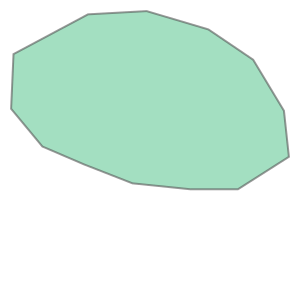

In [11]:
dam_projected

In [12]:
dam_nominal.bounds

(-143.5391237, 37.081476, -142.7178957, 37.4988317)

In [13]:
dam_bbox

BBox(((-143.6212465, 37.03974043), (-142.6357729, 37.54056727)), crs=EPSG:4326)

In [14]:
country_shape = dam_projected
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0]))
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1]))

In [15]:
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))


Dimension of the area is 72634 x 46592 pixels


In [16]:
dam_bbox

BBox(((-143.6212465, 37.03974043), (-142.6357729, 37.54056727)), crs=EPSG:4326)

In [17]:
bbox_splitter = BBoxSplitter([country_shape], patch_crs, (72, 46))


In [18]:
print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))


Area bounding box: BBox(((274833.2676525031, 4105783.056783036), (347468.0656193546, 4152375.6499447436)), crs=EPSG:32607)



In [19]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created. Example:\n'
      '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Each bounding box also has some info how it was created. Example:

bbox: BBox(((274833.2676525031, 4125027.823523741), (275842.0842909316, 4126040.7059837785)), crs=EPSG:32607)
info: {'parent_bbox': BBox(((274833.2676525031, 4105783.056783036), (347468.0656193546, 4152375.6499447436)), crs=EPSG:32607), 'index_x': 0, 'index_y': 19}



In [20]:
len(bbox_splitter.bbox_list)

2613

In [21]:
import pickle

In [22]:
if not os.path.isdir('./tile-def'):
    os.makedirs('./tile-def')
    
with open('./tile-def/pacific_garbage_patch_bbox_4326_17x25_348.pickle', 'wb') as fp:
    pickle.dump(bbox_splitter, fp)

In [23]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf_bboxes = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

In [24]:
gdf_bboxes.head()

,index_x,index_y,geometry
0,0,19,"POLYGON ((274833.2676525031 4125027.823523741,..."
1,0,20,"POLYGON ((274833.2676525031 4126040.705983778,..."
2,0,21,"POLYGON ((274833.2676525031 4127053.588443816,..."
3,0,22,"POLYGON ((274833.2676525031 4128066.470903852,..."
4,0,23,"POLYGON ((274833.2676525031 4129079.35336389, ..."


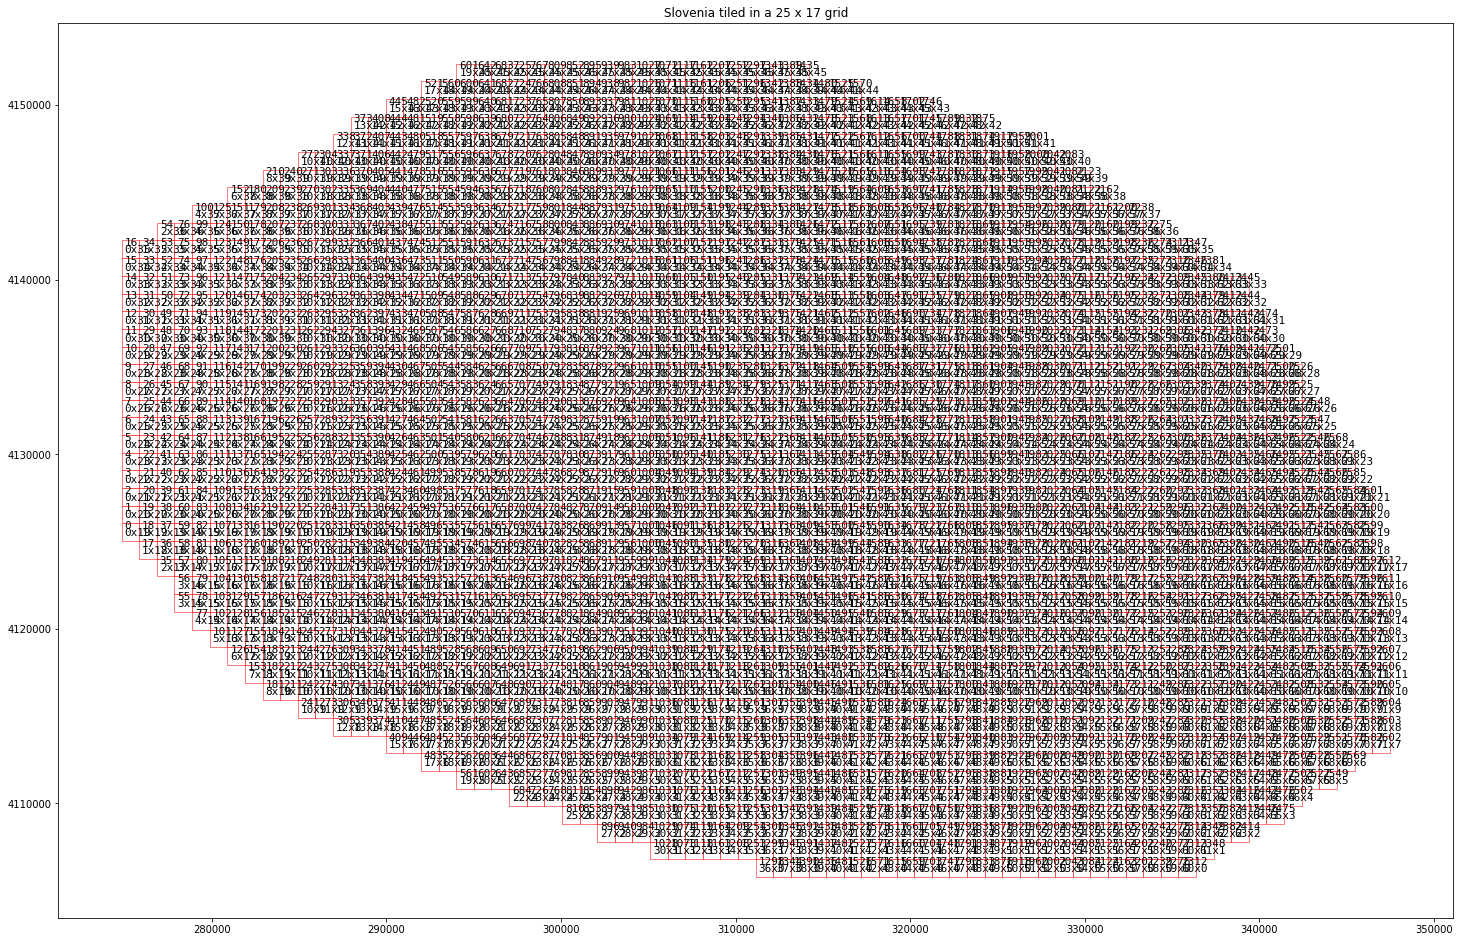

In [25]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf_bboxes.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf_bboxes.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
#dam_nominal.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Slovenia tiled in a 25 x 17 grid');
# add annotiation text
for idx in gdf_bboxes.index:
    eop_name = '{0}x{1}'.format(gdf_bboxes.index_x[idx], gdf_bboxes.index_y[idx])
    centroid, = list(gdf_bboxes.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

if not os.path.isdir('./figs'):
    os.makedirs('./figs')
fig.savefig('./figs/aoi_to_tiles.png', bbox_inches='tight')

In [26]:
gdf_bboxes.to_file('./tile-def/patch_bbox_32633_17x25_293.shp')

/Users/allykoo/anaconda/envs/data-x/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Step 1: Intialize (and implement workflow specific) EOTasks

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [28]:

from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, SaveToDisk, LoadFromDisk, RemoveFeature, OverwritePermission
from eolearn.io import ExportToTiff
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import SimpleFilterTask

In [29]:

from sentinelhub import BBoxSplitter, CRS, MimeType

In [30]:
from pathlib import Path

In [31]:
import logging
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [32]:
data = Path('./')

In [33]:
if not os.path.exists(data/'data'/'valid_count'):
    os.makedirs(data/'data'/'valid_count')

### Get BBoxSplitter with tile definitions


In [34]:
with open(data/'tile-def'/'pacific_garbage_patch_bbox_4326_17x25_348.pickle','rb') as fp:
    bbox_splitter = pickle.load(fp)

In [35]:
len(bbox_splitter.bbox_list)


2613

In [36]:
bbox_splitter.bbox_list[0]


BBox(((274833.2676525031, 4125027.823523741), (275842.0842909316, 4126040.7059837785)), crs=EPSG:32607)

In [37]:
bbox_splitter.info_list[0]


{'parent_bbox': BBox(((274833.2676525031, 4105783.056783036), (347468.0656193546, 4152375.6499447436)), crs=EPSG:32607),
 'index_x': 0,
 'index_y': 19}

### Define a valid pixel

In [38]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask

    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

### Define custom tasks

In [39]:
class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

In [40]:
# 1. Create `EOPatch` by filling it with RGB L1C data
# Add TRUE COLOR from L1C
# The `TRUE-COLOR-S2-L1C` needs to be defined in your configurator
input_task = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='10m', resy='10m', maxcc=0.8, instance_id=INSTANCE_ID)
# want to look at data from sentinel-3 -- can use WCS request
# e.g. layer=layer, data_source=DataSource.SENTINEL2_L1C
# 2. Run SentinelHub's cloud detector
# (cloud detection is performed at 160m resolution
# and the resulting cloud probability map and mask
# are upscaled to EOPatch's resolution)

cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m',
                           cmask_feature='CLM', cprobs_feature='CLP', instance_id=INSTANCE_ID)

# 3. Validate pixels using SentinelHub's cloud detection mask
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 'VALID_DATA_SH')

# 4. Count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('VALID_DATA_SH', 'VALID_COUNT_SH')

# 5. Export valid pixel count to tiff file
export_val_sh = ExportToTiff((FeatureType.MASK_TIMELESS, 'VALID_COUNT_SH'))

# 6. Save EOPatch to disk
save = SaveToDisk(str(data/'data'/'eopatch-L1C'), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


/Users/allykoo/anaconda/envs/data-x/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Finished loading model, total used 170 iterations


In [41]:

workflow = LinearWorkflow(input_task,
                          add_clm,
                          add_sh_valmask, count_val_sh,
                          export_val_sh, save)

In [42]:
print(bbox_splitter.bbox_list[0])

274833.2676525031,4125027.823523741,275842.0842909316,4126040.7059837785


In [44]:
time_interval = ['2017-01-01','2017-12-31']

idx = 0
bbox = bbox_splitter.bbox_list[idx]
info = bbox_splitter.info_list[idx]
print("bbox is ", bbox)
print("info is ", info)
tiff_name = f'val_count_sh_eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
patch_name = f'eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}'
results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                            export_val_sh:{'filename':str(data/'data'/'valid_count'/tiff_name)},
                            save:{'eopatch_folder':patch_name}
                           })

bbox is  274833.2676525031,4125027.823523741,275842.0842909316,4126040.7059837785
info is  {'parent_bbox': BBox(((274833.2676525031, 4105783.056783036), (347468.0656193546, 4152375.6499447436)), crs=EPSG:32607), 'index_x': 0, 'index_y': 19}


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:

patch = list(results.values())[-1]

In [ ]:
patch

In [ ]:
patch.timestamp

In [ ]:
def plot_frame(patch, idx, save_fig=False):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

    axs[0,0].imshow(patch.data['TRUE-COLOR-S2-L1C'][idx])
    axs[0,0].set_title(f'RGB {patch.timestamp[idx]}')
    axs[0,1].imshow(patch.mask['VALID_DATA_SH'][idx, ..., 0],vmin=0,vmax=1)
    axs[0,1].set_title(f'Valid data {patch.timestamp[idx]}')
    axs[1,0].imshow(patch.mask['CLM'][idx,...,0],vmin=0,vmax=1)
    axs[1,0].set_title(f'SentinelHub Cloud Mask {patch.timestamp[idx]}')
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axs[1,1].imshow(patch.data['CLP'][idx,...,0],cmap=plt.cm.inferno, vmin=0.0, vmax=1.0)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[1,1].imshow(patch.data['CLP'][idx,...,0],cmap=plt.cm.inferno)
    axs[1,1].set_title(f'SentinelHub Cloud Probability {patch.timestamp[idx]}')

    if save_fig:
        fig.savefig(f'figs/patch_{idx}_{patch.timestamp[idx]}.png', bbox_inches='tight')
        fig.clf()

In [ ]:
plot_frame(patch, 0)

#### Create an EOPatch and add all EO features (satellite imagery data)

In [ ]:
input_task = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='20m', resy='20m', maxcc=0.5,instance_id=INSTANCE_ID)
add_ndwi = S2L1CWCSInput('NDWI', instance_id=INSTANCE_ID)

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [ ]:
gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'},geometry=[dam_nominal])

In [ ]:
gdf.plot()

In [ ]:
add_nominal_water = VectorToRaster((FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), gdf, 1, 
                                   (FeatureType.MASK, 'IS_DATA'), np.uint8)

#### Run s2cloudless cloud detector and filter out scenes with cloud coverage >20%

To speed up the process hte cloud detection is executed at lower resolution (160m). The resulting cloud probability map and binary mask are stored as `CLP` and `CLM` features in EOPatch.

In [ ]:
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=INSTANCE_ID)

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [ ]:
class ValidDataPredicate:
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [ ]:
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [ ]:
def coverage(array):
    return 1.0 - np.count_nonzero(array)/np.size(array)

In [ ]:
class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        
        cvrg = np.apply_along_axis(coverage, 1, np.reshape(vld, (vld.shape[0], vld.shape[1]*vld.shape[2])))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', cvrg[:,np.newaxis])
        return eopatch

In [ ]:
add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes

In [ ]:
class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = 1.0 - np.count_nonzero(array)/np.size(array)
        return coverage < self.threshold

In [ ]:
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), ValidDataCoveragePredicate(0.2))

#### Apply Water Detection



In [ ]:
def water_detection(ndwi):
    """
    Very simple water detector based on Otsu thresholding method of NDWI.
    """
    otsu_thr = 1.0
    if len(np.unique(ndwi)) > 1:
        otsu_thr = threshold_otsu(ndwi)
    
    return ndwi>otsu_thr

In [ ]:
class WaterDetector(EOTask):
    def execute(self, eopatch):
        water_masks = np.asarray([water_detection(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch

In [ ]:
water_det = WaterDetector()

### Step 2: Define the EOWorkflow

In [ ]:
workflow = EOWorkflow.make_linear_workflow(input_task, add_ndwi, cloud_det, add_nominal_water, add_valmask, add_coverage, remove_cloudy_scenes, water_det)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until end of August 2018.

In [ ]:
time_interval = ['2016-01-01','2018-08-31']

In [ ]:
result = workflow.execute({input_task:{'bbox':dam_bbox, 'time_interval':time_interval},
                          })

In [ ]:
patch=list(result.values())[-1]

Print content of eopatch at the end of the workflow execution

In [ ]:
patch

# Plot results

In [ ]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [ ]:
def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    
    ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal,cmap=plt.cm.Reds)
    ax.imshow(observed,cmap=plt.cm.Blues)
    ax.axis('off')

In [ ]:
plot_rgb_w_water(patch, 0)

In [ ]:
plot_rgb_w_water(patch, -1)

In [ ]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7)
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Theewaterskloof Dam Water Levels')
    ax.grid(axis='y')
    return ax

In [ ]:
ax = plot_water_levels(patch, 1.0)

One observation at the end of 2017 sticks out. Let's visualise it.

In [ ]:
idx = np.where(patch.scalar['WATER_LEVEL']>0.8)[0][0]

In [ ]:
plot_rgb_w_water(patch, idx)

As can be seen the image from this date is covered with clouds, which interfer with water detection algorithms. 
Let's filter the cloudy scene out and plot only water levels for observations with cloud coverage below 2%.

In [ ]:
ax = plot_water_levels(patch, 0.02)